# FINM 36700

# Homework #5 Submission

**Group B 28**

# Imports

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,6]

import warnings
warnings.filterwarnings("ignore")

# Helper Functions

In [2]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [3]:
def tangency_weights(returns, cov_mat = 1):
    
    if cov_mat ==1:
        cov_inv = np.linalg.inv((returns.cov()*12))
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag((cov)))
        covmat = cov_mat * cov + (1-cov_mat) * covmat_diag
        cov_inv = np.linalg.inv((covmat*12))  
        
    ones = np.ones(returns.columns[0:].shape) 
    mu = returns.mean()*12
    scaling = 1/(np.transpose(ones) @ cov_inv @ mu)
    tangent_return = scaling*(cov_inv @ mu) 
    tangency_wts = pd.DataFrame(index = returns.columns[0:], data = tangent_return, columns = ['Tangent Weights'] )
        
    return tangency_wts

In [4]:
def linearRegression(seriesY,seriesX):
    
    mean =seriesY.mean()*12
    sharpe = mean/(seriesY.std()*(12**0.5))
    model = sm.OLS(seriesY,sm.add_constant(seriesX)).fit()
    rsq = model.rsquared
    
    beta = pd.DataFrame(index= [seriesY.name])
    
    for i,x in enumerate(seriesX):
         beta[x] = model.params[i+1]
    
    betaCols = [i+'Beta' for i in seriesX]
    beta = beta.rename(columns = dict(zip(beta.columns,betaCols)))
    
    treynor = mean/beta[beta.columns[0]]
    alpha = model.params[0]*12
    information = alpha/(model.resid.std()*np.sqrt(12))
    
    RegressionStats = pd.DataFrame({'Mean Return':mean,'Sharpe Ratio':sharpe,'R Squared':rsq,\
                         'Alpha':alpha, 'Information Ratio':information, 'Treynor':treynor},index= [seriesY.name])
    
    return pd.concat([RegressionStats,beta], axis =1)

# Reading Data

In [5]:
factors = pd.read_excel(r'factor_pricing_data.xlsx',sheet_name='factors (excess returns)',index_col='Date')
factors.tail()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
2023-03-31,0.0251,-0.0694,-0.0885,0.0224,-0.0237,-0.0249
2023-04-30,0.0061,-0.0256,-0.0004,0.0242,0.0286,0.0163
2023-05-31,0.0035,-0.0038,-0.0772,-0.0181,-0.0722,-0.0063
2023-06-30,0.0646,0.0134,-0.0026,0.0218,-0.0162,-0.0239
2023-07-31,0.0321,0.0286,0.0413,-0.0056,0.0062,-0.0406


In [6]:
portfolios = pd.read_excel('factor_pricing_data.xlsx',sheet_name='portfolios (excess returns)',index_col='Date')
portfolios.tail()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-31,-0.0300,0.0309,0.0479,0.0379,-0.0025,-0.0159,0.0268,-0.0416,0.0480,0.0385,...,-0.0117,-0.0118,0.0025,0.0333,0.0298,-0.1173,-0.0509,-0.0854,-0.0791,0.0206
2023-04-30,-0.0033,0.0258,0.0307,0.0383,0.0375,-0.0342,0.0044,0.0138,0.0401,0.0187,...,-0.0233,-0.0271,0.0010,0.0142,0.0471,0.0139,0.0335,-0.0083,-0.0003,0.0499
2023-05-31,-0.1130,-0.0536,-0.0418,-0.0321,-0.0909,-0.0883,0.0319,-0.0100,-0.0947,-0.1394,...,-0.0646,-0.0010,-0.0163,0.0172,-0.0552,-0.0434,-0.0408,0.0004,-0.0400,-0.0244
2023-06-30,0.0592,-0.0114,0.0097,0.0239,0.0737,0.1033,0.0898,0.0563,0.0680,0.0673,...,0.0746,0.1123,0.1120,0.0754,0.0536,0.0666,0.0335,0.0909,0.0550,0.0633
2023-07-31,-0.0139,0.0166,0.0170,0.0279,0.0104,0.0653,0.0087,0.0349,-0.0012,0.0056,...,0.0510,0.0665,-0.0148,0.0276,0.0240,0.0669,0.0343,0.0479,0.0776,0.0102


# 2 Factors

### 2.1 Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4. You now have three additional factors, so let’s compare their univariate statistics.
- mean 
- volatility 
- Sharpe

#### Beginning - 1980

In [7]:
factor_summary = performance_summary(factors[:'1980'])
factor_summary.loc[:,['Mean','Volatility','Sharpe Ratio']]

,Mean,Volatility,Sharpe Ratio
MKT,0.2029,0.203717,0.995990
SMB,0.0537,0.108821,0.493472
HML,-0.1987,0.117754,-1.687412
RMW,0.1078,0.073037,1.475957
CMA,-0.0977,0.076936,-1.269882
UMD,0.3078,0.234594,1.312054


#### 1981 - 2001

In [8]:
factor_summary = performance_summary(factors['1981':'2001'])
factor_summary.loc[:,['Mean','Volatility','Sharpe Ratio']]

,Mean,Volatility,Sharpe Ratio
MKT,0.077257,0.157396,0.490847
SMB,0.001429,0.109605,0.013034
HML,0.063776,0.111183,0.573612
RMW,0.046914,0.091606,0.512130
CMA,0.053157,0.077355,0.687185
UMD,0.101686,0.145105,0.700775


#### 2002 - End

In [9]:
factor_summary = performance_summary(factors['2002':])
factor_summary.loc[:,['Mean','Volatility','Sharpe Ratio']]

,Mean,Volatility,Sharpe Ratio
MKT,0.086187,0.155313,0.554923
SMB,0.018751,0.090739,0.206642
HML,-0.001710,0.107517,-0.015901
RMW,0.043307,0.075282,0.575261
CMA,0.018417,0.068581,0.268543
UMD,0.009827,0.159709,0.061531


### 2.2 Based on the factor statistics above, answer the following. <br><br> (a) Does each factor have a positive risk premium (positive expected excess return)?

- Beginning - 1980: All factors have a positive risk premium except HML and CMA.
- 1981 - 2001: All factors have a positive risk premium.
- 2002 - End: HML turns to have a negative premium again and all others remain positive.

### (b) How have the factors performed since the time of the case, (2015-present)?

In [10]:
factor_summary = performance_summary(factors['2015':])
factor_summary.loc[:,['Mean','Volatility','Sharpe Ratio']]

,Mean,Volatility,Sharpe Ratio
MKT,0.111705,0.162705,0.686549
SMB,-0.008377,0.098268,-0.085244
HML,-0.025817,0.135825,-0.190080
RMW,0.048594,0.073131,0.664483
CMA,0.001794,0.086965,0.020631
UMD,0.006501,0.144006,0.045144


Market factor (MKT) continues to be the dominant factor with highest annualized returns of $0.112$. RMW has the second best annualized returns of $0.049$. CMA and UMD performed not so well but retain positive returns. SMB and HML have negative annualized mean starting from 2015 till present.

### 2.3 Report the correlation matrix across the six factors.

<Axes: >

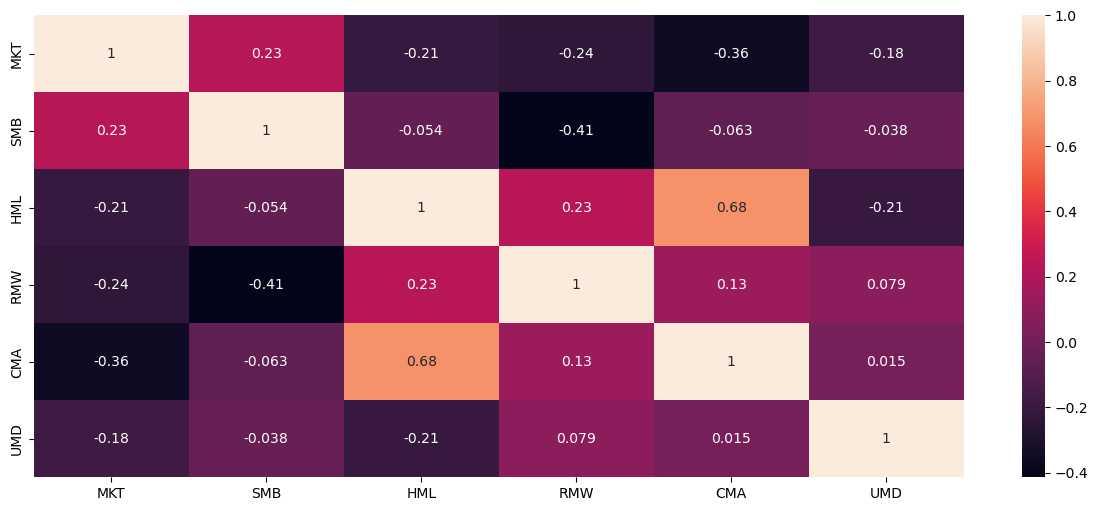

In [11]:
corr = factors.corr()
sns.heatmap(corr,annot=True)

### (a) Does the construction method succeed in keeping correlations small?

In [12]:
sorted_corr = corr.unstack().sort_values().to_frame('Correlations')
sorted_corr = sorted_corr[sorted_corr['Correlations'] != 1]
sorted_corr.T

RMW       SMB      CMA      MKT                 RMW  \
                   SMB       RMW      MKT      CMA       RMW       MKT   
Correlations -0.414346 -0.414346 -0.36208 -0.36208 -0.238199 -0.238199   

                   MKT       HML                 UMD  ...                 RMW  \
                   HML       MKT       UMD       HML  ...       RMW       UMD   
Correlations -0.210772 -0.210772 -0.209087 -0.209087  ...  0.078887  0.078887   

                           CMA      SMB      MKT       HML       RMW  \
                  CMA      RMW      MKT      SMB       RMW       HML   
Correlations  0.13498  0.13498  0.22602  0.22602  0.229786  0.229786   

                   HML       CMA  
                   CMA       HML  
Correlations  0.680955  0.680955  

[1 rows x 30 columns]

Yes. Almost every correlation has a relatively small magnitude based on the heatmap.

Specifically, there are some negative correlations between factors that would lead to better risk minimization objectives, including the correlations between MKT (Market) and CMA (Investment) factors at -0.362, HML (Value) and UMD (Momentum) factors at -0.209, and the correlation between SMB (Size) and RMW (Profitability) factors at 	-0.414. 

Another notable fact is that the correlation between HML (value) and CMA (investment) is relatively high (0.68). 

### (b) Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

The highest two correlation pairs appear to be the correlation of HML with CMA (0.68) and the correlation of HML with RMW (0.23). Given CMA and RMW has a low correlation (0.13), we consider that it is still the case that HML is somewhat redundant in the 5-factor model.

### 2.4 Report the tangency weights for a portfolio of these 6 factors.

In [13]:
w_t = tangency_weights(factors)
w_t.sort_values('Tangent Weights',ascending = False)

,Tangent Weights
CMA,0.369283
RMW,0.307353
MKT,0.203875
UMD,0.093818
SMB,0.087446
HML,-0.061776


### (a) Which factors seem most important? And Least?

- CMA, RMW, and MKT have most of the weights adding up to more than 85% in the tangency portfolio. CMA has the heaviest weight of 37%. 
- HML has a negative tangent weight of -6% in the tangency portfolio. 

### (b) Are the factors with low mean returns still useful?

In [14]:
pd.concat([performance_summary(factors)['Mean'],w_t],axis =1).sort_values('Mean')

,Mean,Tangent Weights
SMB,0.011206,0.087446
HML,0.025324,-0.061776
CMA,0.032492,0.369283
RMW,0.046525,0.307353
UMD,0.060925,0.093818
MKT,0.084562,0.203875


Yes. CMA with only 0.032 of annualized mean return, whereas it still has the most weight in the tangency portfolio of 0.37. Similarly, RMW with a 0.047 annualized mean return has the second weight in the tangency portfolio of 0.31. Combining two together we can get most parts of the portfolio, meaning that the weights in the portfolio are not highly dependent on the mean returns of particular factors.

### (c) Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

In [15]:
w_t_MSHU = tangency_weights(factors[['MKT','SMB','HML','UMD']])
w_t_MSHU.sort_values('Tangent Weights',ascending = False)

,Tangent Weights
MKT,0.356440
HML,0.348903
UMD,0.300861
SMB,-0.006204


In [16]:
pd.concat([performance_summary(factors)['Mean'],w_t_MSHU],axis =1).dropna().sort_values('Mean')

,Mean,Tangent Weights
SMB,0.011206,-0.006204
HML,0.025324,0.348903
UMD,0.060925,0.300861
MKT,0.084562,0.356440




- HML's weight increases substantially from the previous -0.06 to 0.35 despite its low mean returns; UMD's weight increases from 0.09 to 0.30 as well.
- However, SMB's weight drops from 0.09 to -0.006. The weight becomes negative.

### (d) What do you conclude about the importance or unimportance of these styles?



The relative importance of the factors changes over time but the factors have in general maintained a positive return premium. One point that needs to be mentioned is that **HML** has a negative premium in both the Beginning - 1980 and 2002 - End periods, meaning that it loses performance in this portfolio. In addition, the correlation between HML and CMA is relatively high, meaning that HML might be redundant during the portfolio construction.

# 3 Testing Modern LPMs

In [17]:
factors.head()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0551,0.0183,0.0175,-0.0170,0.0164,0.0755
1980-02-29,-0.0122,-0.0157,0.0061,0.0004,0.0268,0.0788
1980-03-31,-0.1290,-0.0693,-0.0101,0.0146,-0.0119,-0.0955
1980-04-30,0.0397,0.0105,0.0106,-0.0210,0.0029,-0.0043
1980-05-31,0.0526,0.0211,0.0038,0.0034,-0.0031,-0.0112


In [18]:
portfolios.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,-0.0076,0.0285,0.0084,0.1009,-0.0143,0.1002,0.0362,0.0323,0.0048,0.0059,...,0.0158,0.0875,0.0465,-0.0126,0.0430,-0.0283,0.0258,0.0768,0.0308,0.0669
1980-02-29,0.0105,-0.0608,-0.0966,-0.0322,-0.0569,-0.0323,-0.0521,-0.0800,-0.0555,-0.0167,...,-0.0079,-0.0541,-0.0346,-0.0639,-0.0652,-0.0854,-0.0959,-0.0347,-0.0282,-0.0274
1980-03-31,-0.2224,-0.1119,-0.0167,-0.1469,-0.0193,-0.1271,-0.0826,-0.1237,-0.0566,-0.0668,...,-0.0819,-0.1509,-0.1098,-0.0906,-0.1449,-0.0560,-0.0880,-0.2451,-0.1254,-0.1726
1980-04-30,0.0449,0.0766,0.0232,0.0321,0.0830,-0.0529,0.0783,0.0153,0.0304,0.0115,...,0.0420,-0.0103,-0.0312,0.0353,0.0542,0.0728,0.0530,0.0977,0.0447,0.0769
1980-05-31,0.0632,0.0793,0.0457,0.0863,0.0815,0.0509,0.0324,0.0886,0.0560,0.0098,...,0.0564,0.1063,0.1142,0.0877,0.1134,0.0578,0.0557,0.0915,0.0844,0.0685


In [19]:
aqr = factors[['MKT', 'HML', 'RMW', 'UMD']]

### 3.1 Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)

### a) For each regression, report the estimated α and r-squared.

In [20]:
frames = []
for col in portfolios:
    p = linearRegression(portfolios[col],aqr)
    frames.append(p)
AQRRegression = pd.concat(frames)
AQRRegression.T

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Mean Return,0.089693,0.099669,0.108840,0.119426,0.132925,0.062946,0.118245,0.074122,0.081545,0.098083,...,0.092398,0.090785,0.085521,0.111818,0.103863,0.088988,0.095899,0.048103,0.110258,0.050820
Sharpe Ratio,0.412541,0.660014,0.490980,0.700661,0.592263,0.252209,0.446060,0.357971,0.529226,0.437351,...,0.462944,0.452969,0.473165,0.596456,0.569968,0.413863,0.526738,0.192725,0.493620,0.239526
R Squared,0.341333,0.471088,0.307178,0.426698,0.272555,0.510315,0.617319,0.689702,0.560258,0.631763,...,0.586154,0.707433,0.756767,0.683464,0.643047,0.772044,0.685298,0.603615,0.812962,0.595904
Alpha,0.009491,0.011434,0.019555,0.024178,0.035317,-0.032189,0.031788,-0.030329,-0.005510,-0.011724,...,0.002115,-0.017072,-0.013517,0.019527,0.002487,-0.022979,-0.008563,-0.056717,0.018242,-0.045176
Information Ratio,0.053788,0.104111,0.105981,0.187339,0.184497,-0.184306,0.193848,-0.262943,-0.053928,-0.086150,...,0.016476,-0.157477,-0.151638,0.185137,0.022844,-0.223835,-0.083839,-0.360927,0.188842,-0.334950
Treynor,0.107052,0.146377,0.138704,0.165106,0.180305,0.056362,0.094682,0.066563,0.108322,0.087683,...,0.094565,0.083035,0.082898,0.113938,0.109533,0.076764,0.097882,0.040084,0.088997,0.047921
MKTBeta,0.837838,0.680903,0.784688,0.723330,0.737220,1.116824,1.248868,1.113566,0.752802,1.118614,...,0.977081,1.093328,1.031640,0.981389,0.948235,1.159250,0.979743,1.200074,1.238895,1.060498
HMLBeta,0.178699,0.169841,0.206106,0.025183,0.249344,-0.035336,0.000177,0.265474,0.000889,0.049475,...,0.116515,0.189071,0.099153,-0.140767,0.080657,0.721895,0.479804,0.490751,0.327216,0.087573
RMWBeta,-0.006405,0.507359,0.494736,0.600586,0.657434,0.230797,-0.109524,0.177919,0.485108,0.564987,...,0.255496,0.352329,0.185132,0.347550,0.500334,0.087560,0.222779,0.062269,-0.401302,0.117101
UMDBeta,0.084119,0.045146,-0.087111,0.090319,-0.026824,-0.150169,-0.230768,-0.077390,0.013206,-0.202276,...,-0.117838,-0.094835,0.011102,-0.054203,-0.067775,-0.138145,-0.014815,-0.196719,-0.038805,-0.022131


In [21]:
AQRRegression[['Alpha','R Squared']].T

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Alpha,0.009491,0.011434,0.019555,0.024178,0.035317,-0.032189,0.031788,-0.030329,-0.005510,-0.011724,...,0.002115,-0.017072,-0.013517,0.019527,0.002487,-0.022979,-0.008563,-0.056717,0.018242,-0.045176
R Squared,0.341333,0.471088,0.307178,0.426698,0.272555,0.510315,0.617319,0.689702,0.560258,0.631763,...,0.586154,0.707433,0.756767,0.683464,0.643047,0.772044,0.685298,0.603615,0.812962,0.595904


### b) Calculate the mean-absolute-error of the estimated alphas, (one for each security, $\tilde{r}^i$.)

### $$MAE = \frac{1}{n}\sum_{i=1}^{n} |\tilde{\alpha}^i|$$

In [22]:
AQR_MAE = round(abs(AQRRegression['Alpha']).mean(),6)
print(f'Mean Absolute Error for AQR factors: {AQR_MAE}')

Mean Absolute Error for AQR factors: 0.022995


### If the pricing model worked, should these alpha estimates be large or small? Why? Based on your MAE stat, does this seem to support the pricing model or not?


- Alpha in finance generally refers to the excess return of an investment relative to the return of a benchmark index. If a pricing model is accurate and there's no skill or additional information not captured by the model, then the alpha should ideally be close to zero. This is because the returns should be explained fully by the model. So, if the pricing model is working properly, alpha estimates should be small. In other words, if we are verifying the validity of equation (1), the favourable evidence is that alpha estimates should be as small as zero after running tests based on equation (2). 

- We observe an MAE stat of 2.3% which might be considered relatively small as compared to the actual portfolio returns in the period, meaning that the factors explain most of the returns for the portfolio. Therefore, the result supports the pricing model. 

### 3.2 Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model. Report the MAE statistic for each of these models and compare it with the AQR Model MAE. Which model fits best?

In [23]:
capm = factors[['MKT']]

frames = []
for col in portfolios:
    p = linearRegression(portfolios[col],capm)
    frames.append(p) 
CAPMRegression = pd.concat(frames)

In [24]:
CAPM_MAE = round(abs(CAPMRegression['Alpha']).mean(),6)
print(f'Mean Absolute Error for CAPM Factor Model: {CAPM_MAE}')

Mean Absolute Error for CAPM Factor Model: 0.020608


In [25]:
ff3 = factors[['MKT', 'SMB', 'HML']]

frames = []
for col in portfolios:
    p = linearRegression(portfolios[col],ff3)
    frames.append(p) 
FF3Regression = pd.concat(frames)

In [26]:
FF3_MAE = round(abs(FF3Regression['Alpha']).mean(),6)
print(f'Mean Absolute Error for FF-3 Factor Model: {FF3_MAE}')

Mean Absolute Error for FF-3 Factor Model: 0.0242


In [27]:
ff5 = factors[['MKT', 'SMB', 'HML', 'RMW', 'CMA']]
frames = []
for col in portfolios:
    p = linearRegression(portfolios[col],ff5)
    frames.append(p) 
FF5Regression = pd.concat(frames)
FF5_MAE = abs(FF3Regression['Alpha']).mean()

In [28]:
FF5_MAE = round(abs(FF5Regression['Alpha']).mean(),6)
print(f'Mean Absolute Error for FF-5 Factor Model: {FF5_MAE}')

Mean Absolute Error for FF-5 Factor Model: 0.031272


In [29]:
mae_df_time_series = pd.DataFrame({'MAE Values':[AQR_MAE, CAPM_MAE, FF3_MAE, FF5_MAE]},\
                    index = ["AQR","CAPM","FF-3","FF-5"])
mae_df_time_series

,MAE Values
AQR,0.022995
CAPM,0.020608
FF-3,0.024200
FF-5,0.031272


- Both FF-3 and FF-5 models have larger MAE values compared with AQR; therefore, the AQR fits better than those two models. 

- However, the CAPM model has an MAE value of 0.021 while the AQR model has an MAE value of 0.023. CAPM fits the most since it has the smallest MAE values if the only determinant is the MAE value. 


### 3.3 Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?


- MAE is getting worse (increasing from 0.024 to 0.031) by adding two more factors into the FF-5 analysis compared with the FF-3 model. Thus signaling that the HML factor may not be a good factor when other factors are included in the model.
- UMD is an important factor since the performance of MAE improves in the AQR model that uses UMD and RMW instead of SMB compared with the FF-3 model.

### 3.4 This does not matter for pricing, but report the average (across n estimations) of the time-series regression r-squared statistics. Do this for each of the three models you tested. Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

In [30]:
AQR_RSq = AQRRegression['R Squared'].mean()
CAPM_RSq = CAPMRegression['R Squared'].mean()
FF3_RSq = FF3Regression['R Squared'].mean()
FF5_RSq = FF5Regression['R Squared'].mean()

In [31]:
r_squared_df = pd.DataFrame({'Average R Squared':[AQR_RSq, CAPM_RSq, FF3_RSq, FF5_RSq]},\
                    index = ["AQR","CAPM","FF-3","FF-5"])
r_squared_df

,Average R Squared
AQR,0.577081
CAPM,0.528087
FF-3,0.572516
FF-5,0.597519


- For all models we tested, the R-squared values are not really high, indicating they are not good models that fully explain the variations in the excess returns. So the factors would not be good in a Linear Factor Decomposition of the assets.

### 3.5 Re-test these models, but this time use the cross-sectional test.

In [32]:
# First summarize the time-series betas from the previous regressions.
time_series_premia = (factors.mean()*12).to_frame('Time Series Premia')
time_series_premia.index = [x+"Beta" for x in time_series_premia.index]
time_series_premia

,Time Series Premia
MKTBeta,0.084562
SMBBeta,0.011206
HMLBeta,0.025324
RMWBeta,0.046525
CMABeta,0.032492
UMDBeta,0.060925


#### AQR Model

In [33]:
import statsmodels.api as sm

y = AQRRegression['Mean Return']
x = AQRRegression[['MKTBeta','HMLBeta','RMWBeta','UMDBeta']]
x = sm.add_constant(x)
AQRRegressionCS = sm.OLS(y,x,missing='drop').fit()
AQR_CS_MAE = abs(AQRRegressionCS.resid).mean()
AQR_CS_Premia = AQRRegressionCS.params.to_frame("AQR CS Premia")
AQR_CS_Premia

,AQR CS Premia
const,0.071431
MKTBeta,0.019933
HMLBeta,-0.033227
RMWBeta,0.023276
UMDBeta,0.002402


#### CAPM Model

In [34]:
# Perform the Cross-sectional Regressions to CAPM model using previous time-series beta.
# Regressor -> 'MKTBeta'
# Regressand -> 'Mean Return' of CAPM model

y = CAPMRegression['Mean Return']
x = CAPMRegression[['MKTBeta']]
x = sm.add_constant(x)
CAPMRegressionCS = sm.OLS(y,x,missing='drop').fit()
CAPM_CS_MAE = abs(CAPMRegressionCS.resid).mean()
CAPM_CS_Premia = CAPMRegressionCS.params.to_frame("CAPM CS Premia")
CAPM_CS_Premia

,CAPM CS Premia
const,0.085643
MKTBeta,0.005514


#### FF3 Model

In [35]:
# Perform the Cross-sectional Regressions to FF3 model using previous time-series beta.
# Regressor -> 'MKTBeta','SMBBeta','HMLBeta'
# Regressand -> 'Mean Return' of FF3 model

y = FF3Regression['Mean Return']
x = FF3Regression[['MKTBeta','SMBBeta','HMLBeta']]
x = sm.add_constant(x)
FF3RegressionCS = sm.OLS(y,x,missing='drop').fit()
FF3_CS_MAE = abs(FF3RegressionCS.resid).mean()
FF3_CS_Premia = FF3RegressionCS.params.to_frame("FF3 CS Premia")
FF3_CS_Premia

,FF3 CS Premia
const,0.061872
MKTBeta,0.039742
SMBBeta,-0.043388
HMLBeta,-0.020863


#### FF5 Model

In [36]:
# Perform the Cross-sectional Regressions to FF5 model using previous time-series beta.
# Regressor -> 'MKTBeta','SMBBeta','HMLBeta','RMWBeta','CMABeta'
# Regressand -> 'Mean Return' of FF5 model

y = FF5Regression['Mean Return']
x = FF5Regression[['MKTBeta','SMBBeta','HMLBeta','RMWBeta','CMABeta']]
x = sm.add_constant(x)
FF5RegressionCS = sm.OLS(y,x,missing='drop').fit()
FF5_CS_MAE = abs(FF5RegressionCS.resid).mean()
FF5_CS_Premia = FF5RegressionCS.params.to_frame("FF5 CS Premia")
FF5_CS_Premia

,FF5 CS Premia
const,0.052766
MKTBeta,0.046425
SMBBeta,-0.046688
HMLBeta,-0.028500
RMWBeta,0.025863
CMABeta,-0.023940


### (a) Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?

In [37]:
pd.concat([time_series_premia,AQR_CS_Premia,CAPM_CS_Premia,FF3_CS_Premia,FF5_CS_Premia],axis = 1).fillna('')

,Time Series Premia,AQR CS Premia,CAPM CS Premia,FF3 CS Premia,FF5 CS Premia
MKTBeta,0.084562,0.019933,0.005514,0.039742,0.046425
SMBBeta,0.011206,,,-0.043388,-0.046688
HMLBeta,0.025324,-0.033227,,-0.020863,-0.0285
RMWBeta,0.046525,0.023276,,,0.025863
CMABeta,0.032492,,,,-0.02394
UMDBeta,0.060925,0.002402,,,
const,,0.071431,0.085643,0.061872,0.052766



- SMBBeta, HMLBeta, and CMABeta have positive TS-premia but negative CS-premia. 
- MKTBeta, RWMBeta and UMDBeta premia are higher for the Time Series-regression than for the Cross-Sectional regression.

### (b) Report the MAE of the cross-sectional regression residuals for each of the four models, (the $v^i$.) How do they compare to the MAE of the time-series alphas?

In [38]:
mae_df_time_series

,MAE Values
AQR,0.022995
CAPM,0.020608
FF-3,0.024200
FF-5,0.031272


In [39]:
mae_df_cs = pd.Series([AQR_CS_MAE,CAPM_CS_MAE,FF3_CS_MAE, FF5_CS_MAE], index = mae_df_time_series.index)
mae_df_cs = mae_df_cs.to_frame()

In [40]:
MAE = pd.concat([mae_df_time_series,mae_df_cs],axis = 1)
MAE.columns = ['Time Series MAE', 'Cross Section MAE']
MAE

,Time Series MAE,Cross Section MAE
AQR,0.022995,0.013738
CAPM,0.020608,0.015638
FF-3,0.024200,0.012258
FF-5,0.031272,0.011547


- Generally, for each model, the MAE of the cross-sectional regression is smaller than the MAE generated from the time-series regression.

---